# PRÁCTICA - million ENTRADAS
MIEMBROS DEL GRUPO: Álvaro Fraile, Esteban Martínez, Alejandro Mendoza, Jaime Alvarez

El cuaderno ha sido ejecutado sobre un contenedor de Docker, con 6 nucleos y 12 hilos.

In [1]:
%pip install numpy tqdm matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import random
from pyspark import SparkContext
import pyspark
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [3]:
num_cores = os.cpu_count()
print(f"Número de núcleos de CPU: {num_cores}")

Número de núcleos de CPU: 12


In [4]:
file_path = './data/botnet_tot_syn_l.csv'

In [5]:
sc = SparkContext("local[*]", "Name of the Program")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/16 12:16:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:

def readFile(filename):
    rdd = sc.textFile(filename)
    rdd_numpy = rdd.map(lambda x : np.array(x.split(","), dtype = float))
    rdd_return = rdd_numpy.map(lambda x : (x[:-1], int(x[-1])))
    return rdd_return

def normalize_value(x, mean, std):
    value = (x[0] - mean) / std
    normalized_val = np.nan_to_num(value, copy=False, nan=0.0)
    return (normalized_val, x[1])

def normalize(RDD_Xy):
    
    rdd_sum = RDD_Xy.reduce(lambda x, y: (np.array(x[0]) + np.array(y[0]), x[1]))
    total_rows = float(RDD_Xy.count())
    mean = rdd_sum[0] / total_rows

    rdd_mean = RDD_Xy.map(lambda x: (x[0], x[1], mean)) 

    rdd_substract = rdd_mean.map(lambda x: (x[0] - x[2]) ** 2)
    rdd_total = rdd_substract.reduce(lambda x, y: x + y)
    std = (rdd_total / total_rows) ** 0.5
 

    rdd_normalized = RDD_Xy.map(lambda x: normalize_value(x, mean, std))
    return rdd_normalized

def predict(w, b, X, threshold=0.5):
    value = np.dot(w, X) + b
    value = 1 / (1 + np.exp(-value))
    return  1 if value > threshold else 0

def loss_function(x):
    return (-x[1] * np.log(x[0]) - (1 - x[1]) * np.log(1 - x[0]))

def calculate_loss_function(predictions_and_targets,lambda_reg,w):   
    """
    Calculate the loss function for logistic regression
    :param predictions_and_targets: RDD with the predictions and the targets
    :param lambda_reg: regularization parameter
    :param w: weights
    :return: loss function
    """

    loss = predictions_and_targets.map(loss_function)
    sum = loss.reduce(lambda x,y: x + y) / predictions_and_targets.count()
    squared_w = np.dot(w, w)
    squared_w = squared_w * lambda_reg / (2 * len(w))
    return sum + squared_w

def predict_train(w, b, X,):
    value = np.dot(w, X) + b
    return 1 / (1 + np.exp(-value))

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

def accuracy(w,b,RDD_Xy):
    predictions_and_targets = RDD_Xy.map(lambda x: (predict(w, b, x[0]), x[1]))
    correct = predictions_and_targets.map(lambda x: 1 if round(x[0]) == x[1] else 0)
    correct = correct.reduce(lambda x, y: x + y)
    return correct / predictions_and_targets.count()

def transform(data,num_blocks_cv):
    data = data.map(lambda x: (random.randint(0, num_blocks_cv-1), x[0], x[1]))
    return data

def get_block_data(data_cv: pyspark.rdd.RDD, i):
    train_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] != i else [])
    test_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] == i else [])
    return train_data, test_data


## **EJERCICIO 1**

In [7]:
n = readFile(file_path)

normalizado = normalize(n)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")

Iteration: 0, Loss: [0.79974711]


Iteration: 1, Loss: [0.5128806]


Iteration: 2, Loss: [0.38490551]


Iteration: 3, Loss: [0.32144001]


Iteration: 4, Loss: [0.2857966]


Iteration: 5, Loss: [0.26324795]


Iteration: 6, Loss: [0.24766062]


Iteration: 7, Loss: [0.23618358]


Iteration: 8, Loss: [0.22733778]


Iteration: 9, Loss: [0.22028356]


Final accuracy: 0.92514


## **EJERCICIO 2**

In [8]:
num_blocks_cv=10
rdd_with_keys = transform(normalizado, num_blocks_cv)
rdd_with_keys.cache()
_ = rdd_with_keys.count() # to cache the data
all_ac=[]
for i in range(num_blocks_cv):
    train_data, test_data = get_block_data(rdd_with_keys, i)
    print("-"*50)
    print(f"Block {i}")
    w,b=train(train_data,10,1.5,0)
    acc=accuracy(w,b,test_data)
    all_ac.append(acc)
    print(f"Accuracy: {acc}")
print(f"Mean accuracy: {np.mean(all_ac)}")

--------------------------------------------------
Block 0


Iteration: 0, Loss: [0.61187593]


Iteration: 1, Loss: [0.41729692]


Iteration: 2, Loss: [0.33807228]


Iteration: 3, Loss: [0.29645201]


Iteration: 4, Loss: [0.27065637]


Iteration: 5, Loss: [0.25295731]


Iteration: 6, Loss: [0.23999519]


Iteration: 7, Loss: [0.23006697]


Iteration: 8, Loss: [0.22220954]


Iteration: 9, Loss: [0.21583326]
Accuracy: 0.9283442525910245
--------------------------------------------------
Block 1


Iteration: 0, Loss: [0.66884692]


Iteration: 1, Loss: [0.44785713]


Iteration: 2, Loss: [0.35375444]


Iteration: 3, Loss: [0.30557643]


Iteration: 4, Loss: [0.27678264]


Iteration: 5, Loss: [0.25757883]


Iteration: 6, Loss: [0.24378693]


Iteration: 7, Loss: [0.23335823]


Iteration: 8, Loss: [0.22517109]


Iteration: 9, Loss: [0.21855797]
Accuracy: 0.9261437257051729
--------------------------------------------------
Block 2


Iteration: 0, Loss: [0.7847804]


Iteration: 1, Loss: [0.47285195]


Iteration: 2, Loss: [0.35544105]


Iteration: 3, Loss: [0.30071123]


Iteration: 4, Loss: [0.26995378]


Iteration: 5, Loss: [0.25032262]


Iteration: 6, Loss: [0.23668666]


Iteration: 7, Loss: [0.22664011]


Iteration: 8, Loss: [0.21891151]


Iteration: 9, Loss: [0.21276686]
Accuracy: 0.9266879684653746
--------------------------------------------------
Block 3


Iteration: 0, Loss: [0.71418816]


Iteration: 1, Loss: [0.44988808]


Iteration: 2, Loss: [0.34616121]


Iteration: 3, Loss: [0.29766615]


Iteration: 4, Loss: [0.27035079]


Iteration: 5, Loss: [0.2526144]


Iteration: 6, Loss: [0.23998168]


Iteration: 7, Loss: [0.23042149]


Iteration: 8, Loss: [0.22287788]


Iteration: 9, Loss: [0.21674267]
Accuracy: 0.9279305325703348
--------------------------------------------------
Block 4


Iteration: 0, Loss: [0.51463069]


Iteration: 1, Loss: [0.36534124]


Iteration: 2, Loss: [0.3018955]


Iteration: 3, Loss: [0.26811928]


Iteration: 4, Loss: [0.24732942]


Iteration: 5, Loss: [0.23326683]


Iteration: 6, Loss: [0.2231177]


Iteration: 7, Loss: [0.21544017]


Iteration: 8, Loss: [0.20942132]


Iteration: 9, Loss: [0.20456875]
Accuracy: 0.928669713252649
--------------------------------------------------
Block 5


Iteration: 0, Loss: [0.49109921]


Iteration: 1, Loss: [0.37002114]


Iteration: 2, Loss: [0.31217018]


Iteration: 3, Loss: [0.27913758]


Iteration: 4, Loss: [0.25781882]


Iteration: 5, Loss: [0.24288035]


Iteration: 6, Loss: [0.23179833]


Iteration: 7, Loss: [0.2232307]


Iteration: 8, Loss: [0.21639787]


Iteration: 9, Loss: [0.21081516]
Accuracy: 0.9296278434209468
--------------------------------------------------
Block 6


Iteration: 0, Loss: [0.53971763]


Iteration: 1, Loss: [0.39031781]


Iteration: 2, Loss: [0.32029929]


Iteration: 3, Loss: [0.2827328]


Iteration: 4, Loss: [0.25981448]


Iteration: 5, Loss: [0.24437752]


Iteration: 6, Loss: [0.23321208]


Iteration: 7, Loss: [0.22470898]


Iteration: 8, Loss: [0.2179812]


Iteration: 9, Loss: [0.21250115]
Accuracy: 0.9299945074149898
--------------------------------------------------
Block 7


Iteration: 0, Loss: [0.57419504]


Iteration: 1, Loss: [0.39808437]


Iteration: 2, Loss: [0.32600693]


Iteration: 3, Loss: [0.28741802]


Iteration: 4, Loss: [0.26331912]


Iteration: 5, Loss: [0.24677652]


Iteration: 6, Loss: [0.23468215]


Iteration: 7, Loss: [0.22543581]


Iteration: 8, Loss: [0.21812817]


Iteration: 9, Loss: [0.21220293]
Accuracy: 0.9295145398699589
--------------------------------------------------
Block 8


Iteration: 0, Loss: [0.73620179]


Iteration: 1, Loss: [0.44166191]


Iteration: 2, Loss: [0.34015927]


Iteration: 3, Loss: [0.29432237]


Iteration: 4, Loss: [0.26782528]


Iteration: 5, Loss: [0.25028515]


Iteration: 6, Loss: [0.23769727]


Iteration: 7, Loss: [0.22816814]


Iteration: 8, Loss: [0.22067469]


Iteration: 9, Loss: [0.21461083]
Accuracy: 0.9244825096277278
--------------------------------------------------
Block 9


Iteration: 0, Loss: [0.65841901]


Iteration: 1, Loss: [0.42220018]


Iteration: 2, Loss: [0.32631694]


Iteration: 3, Loss: [0.28100232]


Iteration: 4, Loss: [0.25565078]


Iteration: 5, Loss: [0.23945829]


Iteration: 6, Loss: [0.22812934]


Iteration: 7, Loss: [0.21969086]


Iteration: 8, Loss: [0.21311889]


Iteration: 9, Loss: [0.2078293]
Accuracy: 0.9310210366341385
Mean accuracy: 0.9282416629552319


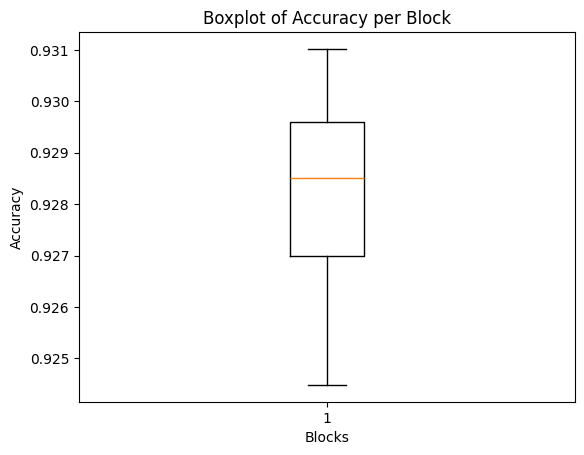

In [9]:
import matplotlib.pyplot as plt
plt.boxplot(all_ac)
plt.xlabel('Blocks')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracy per Block')
plt.show()

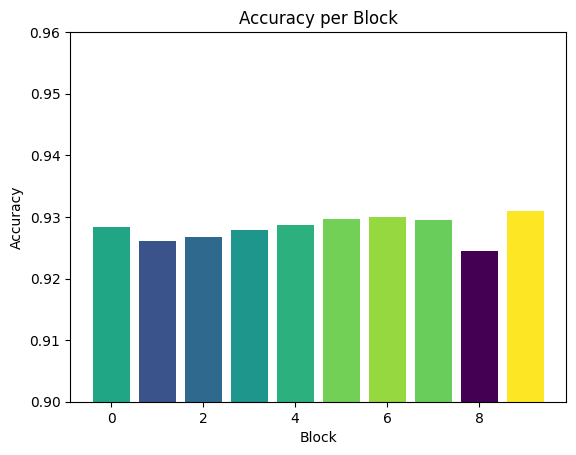

In [10]:
colors = plt.cm.viridis((np.array(all_ac) - min(all_ac)) / (max(all_ac) - min(all_ac)))
plt.bar(range(num_blocks_cv), all_ac, color=colors)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy per Block')
plt.ylim(0.90, 0.96)
plt.show()


# Memoria parte 1

In [11]:
def ej1_train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    costs = []
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        costs.append(loss)
    return w, b, costs

Learning rates: 100%|██████████| 7/7 [16:31<00:00, 141.66s/it]                  


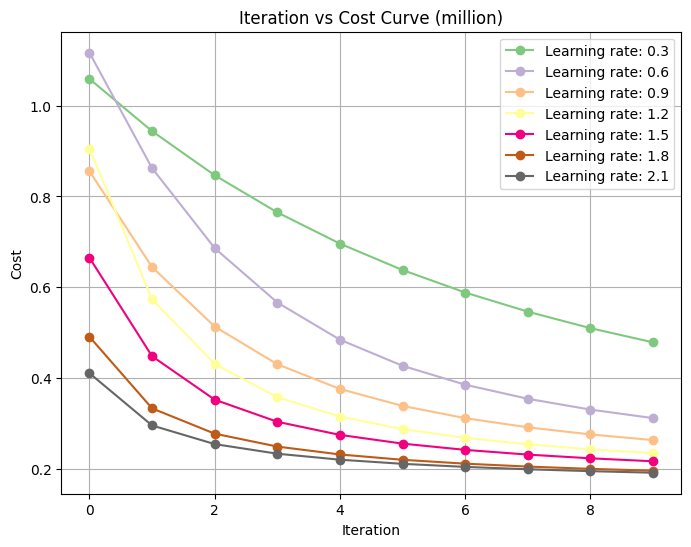

In [12]:
n = readFile(file_path)

normalizado = normalize(n)
total_costs=[]
learning_rates=[0.3,0.6,0.9,1.2,1.5,1.8,2.1]

colors = plt.cm.Accent((np.array(learning_rates) - min(learning_rates)) / (max(learning_rates) - min(learning_rates)))
lambda_reg=0
plt.figure(figsize=(8, 6))
for learning_rate in tqdm(learning_rates, desc=f"Learning rates"):
    w,b,costs=ej1_train(normalizado,10,learning_rate,0)
    total_costs.append(costs)

    plt.plot(costs, marker='o', linestyle='-',color=colors[learning_rates.index(learning_rate)],label=f"Learning rate: {learning_rate}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve (million)")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_learning_rate_million.png")  # Guardar imagen
plt.show()

Lambdas:   0%|          | 0/7 [00:00<?, ?it/s]                                  

0


Lambdas:  14%|█▍        | 1/7 [02:21<14:06, 141.15s/it]                         

0.1


Lambdas:  29%|██▊       | 2/7 [04:41<11:42, 140.44s/it]                         

0.2


Lambdas:  43%|████▎     | 3/7 [07:02<09:23, 140.84s/it]                         

0.3


Lambdas:  57%|█████▋    | 4/7 [09:24<07:04, 141.43s/it]                         

0.4


Lambdas:  71%|███████▏  | 5/7 [11:46<04:43, 141.52s/it]                         

0.5


Lambdas:  86%|████████▌ | 6/7 [14:07<02:21, 141.27s/it]                         

0.6


Lambdas: 100%|██████████| 7/7 [16:27<00:00, 141.04s/it]                         


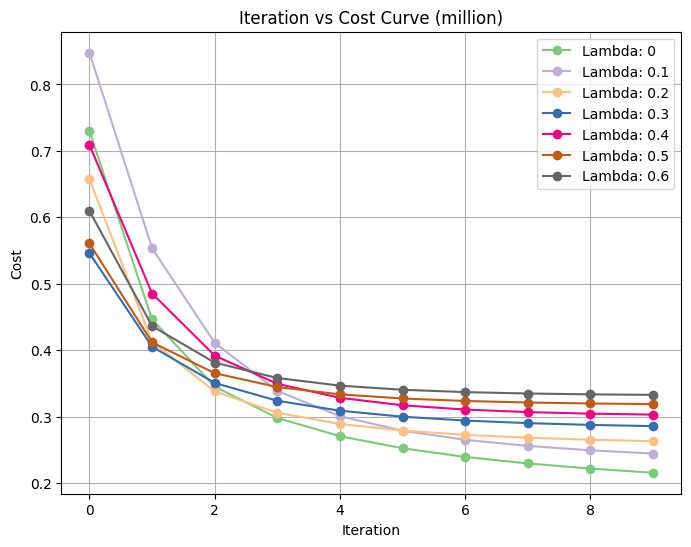

In [13]:
n = readFile(file_path)

normalizado = normalize(n)
lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6]

colors = plt.cm.Accent((np.array(lambdas) - min(lambdas)) / (max(lambdas) - min(lambdas)))
plt.figure(figsize=(8, 6))
for lamb in tqdm(lambdas, desc=f"Lambdas"):
    print(lamb)
    w,b,costs=ej1_train(normalizado,10,1.5,lamb)

    plt.plot(costs, marker='o', linestyle='-',color=colors[lambdas.index(lamb)],label=f"Lambda: {lamb}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve (million)")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_lambda_million.png")  # Guardar imagen
plt.show()

## Memoria Parte 2

Workers: 1, Particiones: 1


Final accuracy: 0.931614


Workers: 2, Particiones: 2


Final accuracy: 0.929765


Workers: 3, Particiones: 3


Final accuracy: 0.93072


Workers: 4, Particiones: 4


Final accuracy: 0.930095


Workers: 5, Particiones: 5


Final accuracy: 0.931136


Workers: 6, Particiones: 6


Final accuracy: 0.930785


Workers: 7, Particiones: 7


Final accuracy: 0.929308


Workers: 8, Particiones: 8


Final accuracy: 0.929039


Workers: 9, Particiones: 9


Final accuracy: 0.927774


Workers: 10, Particiones: 10


Final accuracy: 0.927805


Workers: 11, Particiones: 11


Final accuracy: 0.931411


Workers: 12, Particiones: 12


Final accuracy: 0.929703


Workers: 13, Particiones: 13


Final accuracy: 0.929567


Workers: 14, Particiones: 14


Final accuracy: 0.929511


Workers: 15, Particiones: 15


Final accuracy: 0.930917


Workers: 16, Particiones: 16


Final accuracy: 0.930305


Workers: 17, Particiones: 17


Final accuracy: 0.923881


Workers: 18, Particiones: 18


Final accuracy: 0.928805


Workers: 19, Particiones: 19


Final accuracy: 0.93181


Workers: 20, Particiones: 20


Final accuracy: 0.928634


Workers: 30, Particiones: 30


Final accuracy: 0.93007


Workers: 40, Particiones: 40


Final accuracy: 0.926443


Workers: 50, Particiones: 50


Final accuracy: 0.929135


Workers: 100, Particiones: 100


Final accuracy: 0.928693


Ejecutando pruebas: 100%|██████████| 24/24 [34:03<00:00, 85.15s/it]


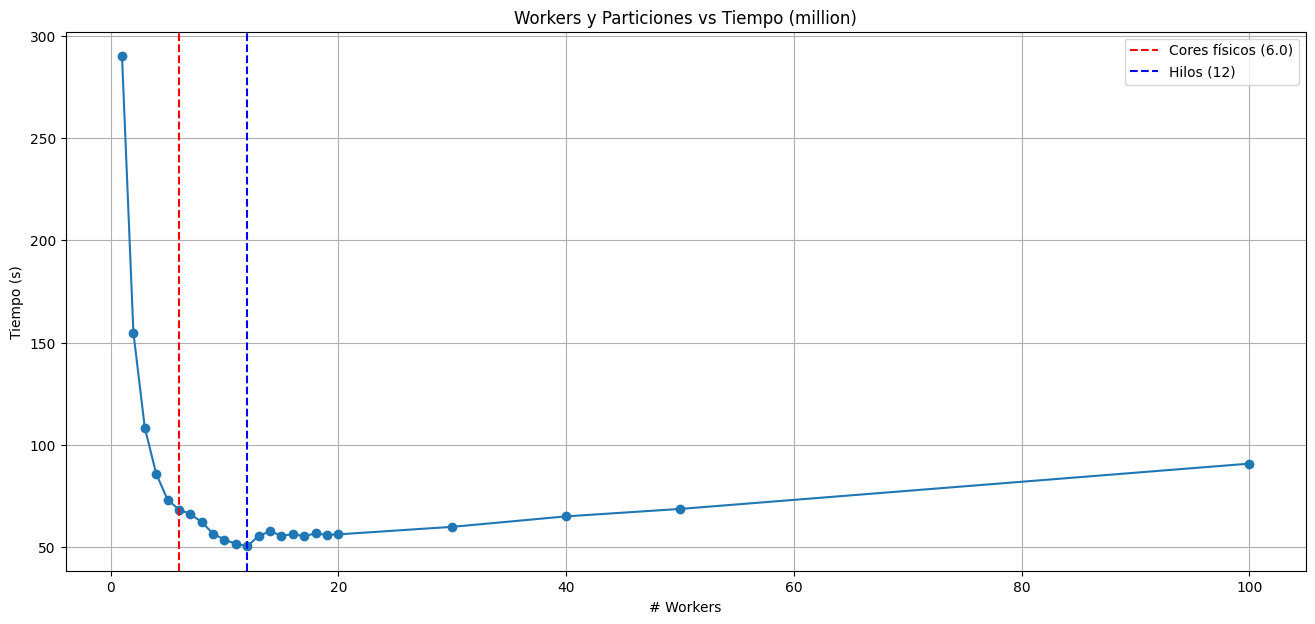

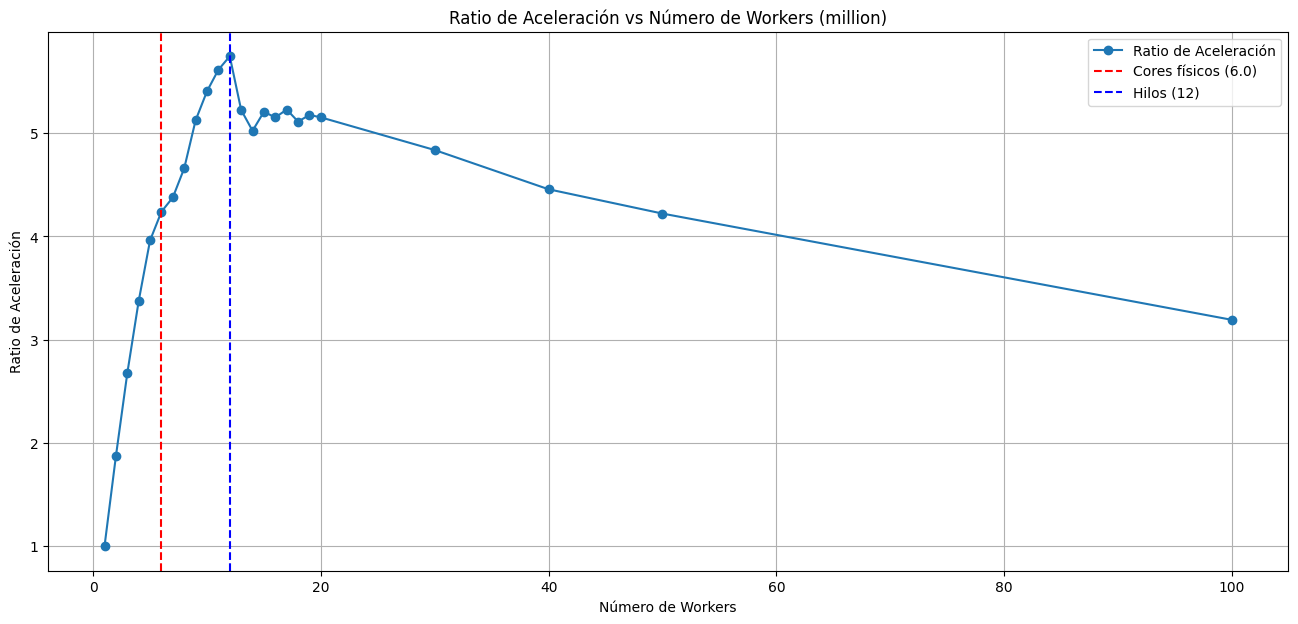

Tiempo de ejecución 34.07773523330688 minutos


In [14]:
inicial_inicial = time.time()
# Número de workers y particiones a probar
workers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 100]
# workers = [16, 17, 18, 19, 20]

# Obtener número de cores físicos y lógicos
num_hilos = os.cpu_count()  # Total de hilos (CPU lógicos)
num_cores = num_hilos / 2  # Cores físicos, asumo la mitad de hilos

try:
    sc.stop()
except:
    pass

plt.figure(figsize=(16, 7))
totals_por_workers = {}  # Almacenar tiempos por número de particiones

for worker in tqdm(workers, desc="Ejecutando pruebas"):
    p = worker  # Particiones igual a número de workers

    sc = SparkContext(f"local[{worker}]", "Name of the Program")
    
    n = readFile(file_path)
    
    normalizado = normalize(n)
    normalizado = normalizado.repartition(p)

    print(f"Workers: {worker}, Particiones: {normalizado.getNumPartitions()}")

    inicio = time.time()
    
    w, b, costs=ej1_train(normalizado,10,1.5,0)

    fin = time.time()
    
    acc=accuracy(w,b,normalizado)
    print(f"Final accuracy: {acc}")
    sc.stop()
    totals_por_workers[p] = fin - inicio

# Graficar
plt.plot(totals_por_workers.keys(), totals_por_workers.values(), marker='o', linestyle='-')

# Configurar la gráfica
plt.axvline(x=num_cores, color='r', linestyle='--', label=f'Cores físicos ({num_cores})')
plt.axvline(x=num_hilos, color='b', linestyle='--', label=f'Hilos ({num_hilos})')

plt.xlabel("# Workers")
plt.ylabel("Tiempo (s)")
plt.title("Workers y Particiones vs Tiempo (million)")
plt.legend()
plt.grid()
plt.savefig("results/Ej_2_time_workers_million.png")
plt.show()

# ==========================
# Cálculo del Ratio de Aceleración
# ==========================

plt.figure(figsize=(16, 7))

tiempo_worker_1 = totals_por_workers[1]  # Tiempo con 1 worker
ratios = {worker: tiempo_worker_1 / totals_por_workers[worker] for worker in workers}  # Calcular el ratio de aceleración 

# Graficar el ratio de aceleración
plt.plot(list(ratios.keys()), list(ratios.values()), marker='o', linestyle='-', label="Ratio de Aceleración")

# Marcar líneas verticales para cores físicos y hilos
plt.axvline(x=num_cores, color='r', linestyle='--', label=f'Cores físicos ({num_cores})')
plt.axvline(x=num_hilos, color='b', linestyle='--', label=f'Hilos ({num_hilos})')

plt.xlabel("Número de Workers")
plt.ylabel("Ratio de Aceleración")
plt.title("Ratio de Aceleración vs Número de Workers (million)")
plt.legend()
plt.grid()
plt.savefig("results/Ej_2_speed_up_million.png")
plt.show()

final_final = time.time()
print(f"Tiempo de ejecución {(final_final - inicial_inicial)/60} minutos")


## Memoria Parte 3

### Tiempo normal

In [15]:
sc = SparkContext("local[12]", "Name of the Program")

In [16]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado = normalizado.repartition(12)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
normal_time = end_time - start_time
print(normal_time)

Iteration: 0, Loss: [0.55657546]


Iteration: 1, Loss: [0.38412984]


Iteration: 2, Loss: [0.31442123]


Iteration: 3, Loss: [0.27826309]


Iteration: 4, Loss: [0.25623065]


Iteration: 5, Loss: [0.24132944]


Iteration: 6, Loss: [0.23051326]


Iteration: 7, Loss: [0.22225803]


Iteration: 8, Loss: [0.21571933]


Iteration: 9, Loss: [0.21039169]


Final accuracy: 0.929825
56.082757234573364


### Cacheamos el normalizado

In [17]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado = normalizado.repartition(12)
normalizado.cache()
_ = normalizado.count()
w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_normalizado = end_time - start_time
print(cached_normalizado)

Iteration: 0, Loss: [0.81187038]


Iteration: 1, Loss: [0.50463392]


Iteration: 2, Loss: [0.37477233]


Iteration: 3, Loss: [0.31432005]


Iteration: 4, Loss: [0.28084641]


Iteration: 5, Loss: [0.25957482]


Iteration: 6, Loss: [0.24477062]


Iteration: 7, Loss: [0.2338142]


Iteration: 8, Loss: [0.22534187]


Iteration: 9, Loss: [0.21857211]


Final accuracy: 0.927245
55.904824018478394


### Cachemos gradientes

In [18]:
def train_cached_grad(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        gradients.cache()
        _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [19]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado = normalizado.repartition(12)
# normalizado.cache()
# _ = normalizado.count()
w,b=train_cached_grad(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_gradients = end_time - start_time
print(cached_gradients)

Iteration: 0, Loss: [0.78289603]


Iteration: 1, Loss: [0.49787976]


Iteration: 2, Loss: [0.37514783]


Iteration: 3, Loss: [0.31469772]


Iteration: 4, Loss: [0.28061563]


Iteration: 5, Loss: [0.25900065]


Iteration: 6, Loss: [0.24405532]


Iteration: 7, Loss: [0.2330618]


Iteration: 8, Loss: [0.22460026]


Iteration: 9, Loss: [0.21786117]


Final accuracy: 0.926303
69.9609899520874


### Cachemos gradients y normalizado

In [20]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado = normalizado.repartition(12)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_grad(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_gradients_normalizado = end_time - start_time
print(cached_gradients_normalizado)

Iteration: 0, Loss: [0.66120736]


Iteration: 1, Loss: [0.4281181]


Iteration: 2, Loss: [0.33954969]


Iteration: 3, Loss: [0.29609796]


Iteration: 4, Loss: [0.27026356]


Iteration: 5, Loss: [0.25291114]


Iteration: 6, Loss: [0.24031447]


Iteration: 7, Loss: [0.23068152]


Iteration: 8, Loss: [0.22303856]


Iteration: 9, Loss: [0.21680652]


Final accuracy: 0.926445
72.06318974494934


### Cacheamos el predict en el train

In [21]:
def train_cached_pred(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        predictions_targets_inputs.cache()
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        # gradients.cache()
        # _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [22]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado = normalizado.repartition(12)
# normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict = end_time - start_time
print(cached_predict)

Iteration: 0, Loss: [1.50126976]


Iteration: 1, Loss: [0.77896225]


Iteration: 2, Loss: [0.47156823]


Iteration: 3, Loss: [0.3550018]


Iteration: 4, Loss: [0.3021635]


Iteration: 5, Loss: [0.27251684]


Iteration: 6, Loss: [0.25340643]


Iteration: 7, Loss: [0.23995704]


Iteration: 8, Loss: [0.22991733]


Iteration: 9, Loss: [0.2221015]


Final accuracy: 0.926312
61.90715742111206


### Chacheamos predict y grads

In [23]:
def train_cached(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        predictions_targets_inputs.cache()
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        gradients.cache()
        _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [24]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado = normalizado.repartition(12)
# normalizado.cache()
_ = normalizado.count()
w,b=train_cached(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict_grad = end_time - start_time
print(cached_predict_grad)

Iteration: 0, Loss: [1.36484674]


Iteration: 1, Loss: [0.69729713]


Iteration: 2, Loss: [0.44629466]


Iteration: 3, Loss: [0.34652639]


Iteration: 4, Loss: [0.29687272]


Iteration: 5, Loss: [0.26777327]


Iteration: 6, Loss: [0.24875887]


Iteration: 7, Loss: [0.23537585]


Iteration: 8, Loss: [0.22544282]


Iteration: 9, Loss: [0.2177728]


Final accuracy: 0.928989
77.5316092967987


### Cacheamos predict y normalizado

In [25]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado = normalizado.repartition(12)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict_norm = end_time - start_time
print(cached_predict_norm)

Iteration: 0, Loss: [1.52192372]


Iteration: 1, Loss: [0.7354856]


Iteration: 2, Loss: [0.44706451]


Iteration: 3, Loss: [0.34373617]


Iteration: 4, Loss: [0.29458445]


Iteration: 5, Loss: [0.26620597]


Iteration: 6, Loss: [0.24770625]


Iteration: 7, Loss: [0.23465334]


Iteration: 8, Loss: [0.22492516]


Iteration: 9, Loss: [0.21737926]


Final accuracy: 0.929484
61.92931628227234


### Combinamos los tres

In [26]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado = normalizado.repartition(12)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_all = end_time - start_time
print(cached_all)

Iteration: 0, Loss: [1.35719257]


Iteration: 1, Loss: [0.70225539]


Iteration: 2, Loss: [0.4451146]


Iteration: 3, Loss: [0.33964455]


Iteration: 4, Loss: [0.28973591]


Iteration: 5, Loss: [0.26198715]


Iteration: 6, Loss: [0.24442768]


Iteration: 7, Loss: [0.23225873]


Iteration: 8, Loss: [0.22326895]


Iteration: 9, Loss: [0.21631321]


Final accuracy: 0.929409
60.23256325721741


### Plot

[56.082757234573364, 55.904824018478394, 69.9609899520874, 72.06318974494934, 61.90715742111206, 77.5316092967987, 61.92931628227234, 60.23256325721741]


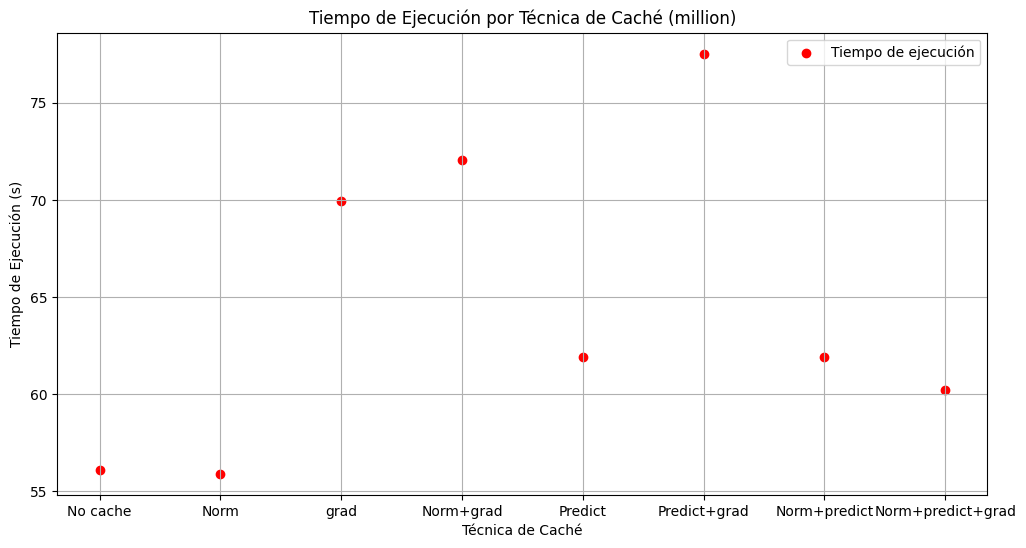

In [27]:
tecnicas_cache = ["No cache", "Norm", "grad", "Norm+grad", "Predict", 'Predict+grad', 'Norm+predict','Norm+predict+grad']
tiempos_cache = [normal_time, cached_normalizado, cached_gradients, cached_gradients_normalizado, cached_predict, cached_predict_grad, cached_predict_norm, cached_all]  # Ejemplo de tiempos en segundos
print(tiempos_cache)
plt.figure(figsize=(12, 6))
plt.scatter(tecnicas_cache, tiempos_cache, color='r', label='Tiempo de ejecución')
plt.xlabel("Técnica de Caché")
plt.ylabel("Tiempo de Ejecución (s)")
plt.title("Tiempo de Ejecución por Técnica de Caché (million)")
plt.legend()
plt.grid()
plt.savefig(f"results/Ej_3a_cached_million.png") 

plt.show()


## Memoria Parte 3B

Workers: 1, Particiones: 1


Final accuracy: 0.928948


Workers: 2, Particiones: 2


Final accuracy: 0.927427


Workers: 3, Particiones: 3


Final accuracy: 0.925058


Workers: 4, Particiones: 4


Final accuracy: 0.930526


Workers: 5, Particiones: 5


Final accuracy: 0.929044


Workers: 6, Particiones: 6


Final accuracy: 0.929113


Workers: 7, Particiones: 7


Final accuracy: 0.924715


Workers: 8, Particiones: 8


Final accuracy: 0.926755


Workers: 9, Particiones: 9


Final accuracy: 0.928778


Workers: 10, Particiones: 10


Final accuracy: 0.927835


Workers: 11, Particiones: 11


Final accuracy: 0.925752


Workers: 12, Particiones: 12


Final accuracy: 0.930977


Workers: 13, Particiones: 13


Final accuracy: 0.929099


Workers: 14, Particiones: 14


Final accuracy: 0.923962


Workers: 15, Particiones: 15


Final accuracy: 0.928648


Workers: 16, Particiones: 16


Final accuracy: 0.927343


Workers: 17, Particiones: 17


Final accuracy: 0.929858


Workers: 18, Particiones: 18


Final accuracy: 0.925042


Workers: 19, Particiones: 19


Final accuracy: 0.927576


Workers: 20, Particiones: 20


Final accuracy: 0.930344


Workers: 30, Particiones: 30


Final accuracy: 0.926998


Workers: 40, Particiones: 40


Final accuracy: 0.930384


Workers: 50, Particiones: 50


Final accuracy: 0.926819


Workers: 100, Particiones: 100


Final accuracy: 0.928763


Ejecutando pruebas: 100%|██████████| 24/24 [34:10<00:00, 85.44s/it]


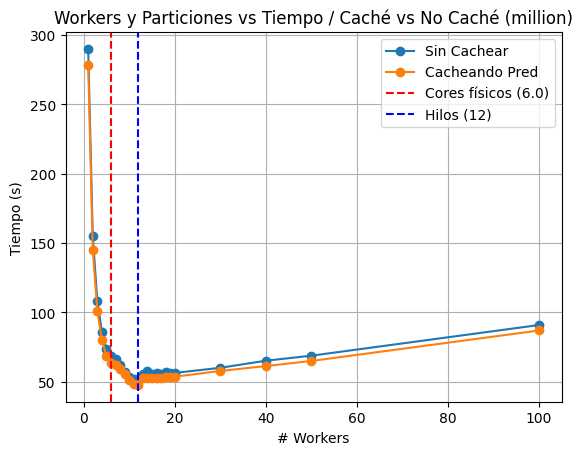

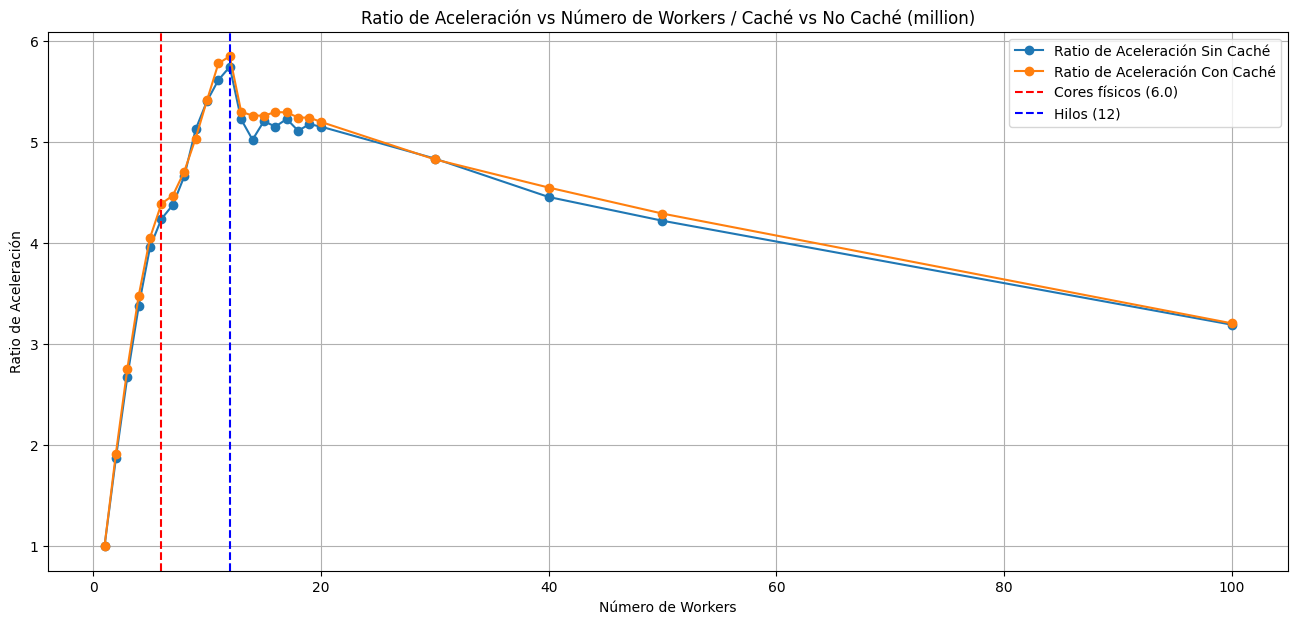

Tiempo de ejecución 34.19430229663849 minutos


In [28]:
inicial_inicial = time.time()
# Número de workers y particiones a probar
workers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 100]

# Obtener número de cores físicos y lógicos
num_hilos = os.cpu_count()  # Total de hilos (CPU lógicos)
num_cores = num_hilos / 2  # Cores físicos, asumo la mitad de hilos

try:
    sc.stop()
except:
    pass

# Cache predict
totals_por_workers_c = {}  # Almacenar tiempos por número de particiones

for worker in tqdm(workers, desc="Ejecutando pruebas"):
    p = worker  # Particiones igual a número de workers

    sc = SparkContext(f"local[{worker}]", "Name of the Program")
    
    n = readFile(file_path)
    
    normalizado = normalize(n)
    normalizado = normalizado.repartition(p)
    normalizado.cache()
    _ = normalizado.count()

    print(f"Workers: {worker}, Particiones: {normalizado.getNumPartitions()}")

    inicio = time.time()
    
    w, b, costs=ej1_train(normalizado,10,1.5,0)

    fin = time.time()
    
    acc=accuracy(w,b,normalizado)
    print(f"Final accuracy: {acc}")
    sc.stop()
    totals_por_workers_c[p] = fin - inicio

# Graficar en la misma figura
plt.plot(totals_por_workers.keys(), totals_por_workers.values(), marker='o', linestyle='-', label=f"Sin Cachear")
plt.plot(totals_por_workers_c.keys(), totals_por_workers_c.values(), marker='o', linestyle='-', label=f"Cacheando Pred")

# Configurar la gráfica
plt.axvline(x=num_cores, color='r', linestyle='--', label=f'Cores físicos ({num_cores})')
plt.axvline(x=num_hilos, color='b', linestyle='--', label=f'Hilos ({num_hilos})')

plt.xlabel("# Workers")
plt.ylabel("Tiempo (s)")
plt.title("Workers y Particiones vs Tiempo / Caché vs No Caché (million)")
plt.legend()
plt.grid()
plt.savefig("results/Ej_3b_time_workers_cache_million.png")
plt.show()

# ==========================
# Cálculo del Ratio de Aceleración
# ==========================

plt.figure(figsize=(16, 7))

tiempo_worker_1 = totals_por_workers[1]  # Tiempo con 1 worker
ratios = {worker: tiempo_worker_1 / totals_por_workers[worker] for worker in workers}  # Calcular el ratio de aceleración 

tiempo_worker_1_c = totals_por_workers_c[1]  # Tiempo con 1 worker
ratios_c = {worker: tiempo_worker_1_c / totals_por_workers_c[worker] for worker in workers}  # Calcular el ratio de aceleración 

# Graficar el ratio de aceleración
plt.plot(list(ratios.keys()), list(ratios.values()), marker='o', linestyle='-', label="Ratio de Aceleración Sin Caché")
plt.plot(list(ratios_c.keys()), list(ratios_c.values()), marker='o', linestyle='-', label="Ratio de Aceleración Con Caché")

# Marcar líneas verticales para cores físicos y hilos
plt.axvline(x=num_cores, color='r', linestyle='--', label=f'Cores físicos ({num_cores})')
plt.axvline(x=num_hilos, color='b', linestyle='--', label=f'Hilos ({num_hilos})')

plt.xlabel("Número de Workers")
plt.ylabel("Ratio de Aceleración")
plt.title("Ratio de Aceleración vs Número de Workers / Caché vs No Caché (million)")
plt.legend()
plt.grid()
plt.savefig("results/Ej_3b_speed_up_cache_million.png")
plt.show()

final_final = time.time()
print(f"Tiempo de ejecución {(final_final - inicial_inicial)/60} minutos")


## Memoria Parte 4

In [ ]:
partitions=range(1,9)

try:
    sc.stop()
except:
    pass
sc = SparkContext(f"local[{4}]", "Name of the Program")
totals=[]
plt.figure(figsize=(8, 6))
for partition in tqdm(partitions, desc=f"Partitions"):
    print(partition)
    n = readFile(file_path)   
    normalizado = normalize(n)
    normalizado=normalizado.repartition(partition)

    inicio=time.time()
    w,b,costs=ej1_train(normalizado,10,1.5,0)
    fin=time.time()
    totals.append(fin-inicio)

plt.plot(range(1, len(totals) + 1), totals, marker='o', linestyle='-')
plt.xlabel("# Partitions")
plt.ylabel("Time (s)")
plt.title("Partitions vs Time (million)")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_4_time_partitions_million.png") 
plt.show()

Partitions:   0%|          | 0/8 [00:00<?, ?it/s]

1


## Memoria - Anexo

Workers (particiones=2):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 2


Workers (particiones=2):   7%|▋         | 1/14 [00:12<02:48, 12.95s/it]

Workers: 2, Particiones: 2


Workers (particiones=2):  14%|█▍        | 2/14 [00:19<01:51,  9.27s/it]

Workers: 3, Particiones: 2


Workers (particiones=2):  21%|██▏       | 3/14 [00:26<01:30,  8.19s/it]

Workers: 4, Particiones: 2


Workers (particiones=2):  29%|██▊       | 4/14 [00:33<01:16,  7.64s/it]

Workers: 5, Particiones: 2


Workers (particiones=2):  36%|███▌      | 5/14 [00:40<01:07,  7.45s/it]

Workers: 6, Particiones: 2


Workers (particiones=2):  43%|████▎     | 6/14 [00:49<01:03,  7.96s/it]         

Workers: 7, Particiones: 2


Workers (particiones=2):  50%|█████     | 7/14 [00:57<00:55,  7.91s/it]

Workers: 8, Particiones: 2


Workers (particiones=2):  57%|█████▋    | 8/14 [01:03<00:45,  7.53s/it]

Workers: 9, Particiones: 2


Workers (particiones=2):  64%|██████▍   | 9/14 [01:10<00:36,  7.26s/it]

Workers: 10, Particiones: 2


Workers (particiones=2):  71%|███████▏  | 10/14 [01:19<00:30,  7.68s/it]

Workers: 15, Particiones: 2


Workers (particiones=2):  79%|███████▊  | 11/14 [01:25<00:22,  7.37s/it]

Workers: 20, Particiones: 2


Workers (particiones=2):  86%|████████▌ | 12/14 [01:32<00:14,  7.10s/it]

Workers: 30, Particiones: 2


Workers (particiones=2):  93%|█████████▎| 13/14 [01:39<00:06,  6.96s/it]

Workers: 50, Particiones: 2


Workers (particiones=6):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 6


Workers (particiones=6):   7%|▋         | 1/14 [00:26<05:43, 26.39s/it]

Workers: 2, Particiones: 6


Workers (particiones=6):  14%|█▍        | 2/14 [00:42<04:05, 20.45s/it]         

Workers: 3, Particiones: 6


Workers (particiones=6):  21%|██▏       | 3/14 [00:53<02:55, 15.99s/it]

Workers: 4, Particiones: 6


Workers (particiones=6):  29%|██▊       | 4/14 [01:03<02:16, 13.60s/it]

Workers: 5, Particiones: 6


Workers (particiones=6):  36%|███▌      | 5/14 [01:15<01:56, 12.95s/it]         

Workers: 6, Particiones: 6


Workers (particiones=6):  43%|████▎     | 6/14 [01:22<01:27, 10.97s/it]

Workers: 7, Particiones: 6


Workers (particiones=6):  50%|█████     | 7/14 [01:29<01:07,  9.71s/it]

Workers: 8, Particiones: 6


Workers (particiones=6):  57%|█████▋    | 8/14 [01:38<00:57,  9.53s/it]

Workers: 9, Particiones: 6


Workers (particiones=6):  64%|██████▍   | 9/14 [01:45<00:44,  8.82s/it]

Workers: 10, Particiones: 6


Workers (particiones=6):  71%|███████▏  | 10/14 [01:52<00:32,  8.25s/it]

Workers: 15, Particiones: 6


Workers (particiones=6):  79%|███████▊  | 11/14 [01:59<00:23,  7.91s/it]

Workers: 20, Particiones: 6


Workers (particiones=6):  86%|████████▌ | 12/14 [02:06<00:15,  7.67s/it]

Workers: 30, Particiones: 6


Workers (particiones=6):  93%|█████████▎| 13/14 [02:16<00:08,  8.10s/it]        

Workers: 50, Particiones: 6


Workers (particiones=8):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 8


Workers (particiones=8):   7%|▋         | 1/14 [00:32<07:07, 32.92s/it]         

Workers: 2, Particiones: 8


Workers (particiones=8):  14%|█▍        | 2/14 [00:51<04:57, 24.77s/it]         

Workers: 3, Particiones: 8


Workers (particiones=8):  21%|██▏       | 3/14 [01:06<03:38, 19.86s/it]

Workers: 4, Particiones: 8


Workers (particiones=8):  29%|██▊       | 4/14 [01:16<02:43, 16.32s/it]

Workers: 5, Particiones: 8


Workers (particiones=8):  36%|███▌      | 5/14 [01:29<02:13, 14.86s/it]

Workers: 6, Particiones: 8


Workers (particiones=8):  43%|████▎     | 6/14 [01:38<01:45, 13.14s/it]

Workers: 7, Particiones: 8


Workers (particiones=8):  50%|█████     | 7/14 [01:48<01:24, 12.07s/it]

Workers: 8, Particiones: 8


Workers (particiones=8):  57%|█████▋    | 8/14 [01:58<01:06, 11.16s/it]

Workers: 9, Particiones: 8


Workers (particiones=8):  64%|██████▍   | 9/14 [02:05<00:49,  9.93s/it]

Workers: 10, Particiones: 8


Workers (particiones=8):  71%|███████▏  | 10/14 [02:12<00:36,  9.07s/it]

Workers: 15, Particiones: 8


Workers (particiones=8):  79%|███████▊  | 11/14 [02:19<00:25,  8.50s/it]

Workers: 20, Particiones: 8


Workers (particiones=8):  86%|████████▌ | 12/14 [02:28<00:17,  8.73s/it]

Workers: 30, Particiones: 8


Workers (particiones=8):  93%|█████████▎| 13/14 [02:36<00:08,  8.27s/it]

Workers: 50, Particiones: 8


Workers (particiones=10):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 10


Workers (particiones=10):   7%|▋         | 1/14 [00:38<08:26, 39.00s/it]        

Workers: 2, Particiones: 10


Workers (particiones=10):  14%|█▍        | 2/14 [01:00<05:47, 28.99s/it]        

Workers: 3, Particiones: 10


Workers (particiones=10):  21%|██▏       | 3/14 [01:19<04:25, 24.14s/it]

Workers: 4, Particiones: 10


Workers (particiones=10):  29%|██▊       | 4/14 [01:32<03:18, 19.81s/it]

Workers: 5, Particiones: 10


Workers (particiones=10):  36%|███▌      | 5/14 [01:43<02:29, 16.63s/it]

Workers: 6, Particiones: 10


Workers (particiones=10):  43%|████▎     | 6/14 [01:55<02:01, 15.18s/it]

Workers: 7, Particiones: 10


Workers (particiones=10):  50%|█████     | 7/14 [02:05<01:34, 13.49s/it]

Workers: 8, Particiones: 10


Workers (particiones=10):  57%|█████▋    | 8/14 [02:15<01:14, 12.38s/it]

Workers: 9, Particiones: 10


Workers (particiones=10):  64%|██████▍   | 9/14 [02:27<01:01, 12.24s/it]        

Workers: 10, Particiones: 10


Workers (particiones=10):  71%|███████▏  | 10/14 [02:35<00:42, 10.70s/it]

Workers: 15, Particiones: 10


Workers (particiones=10):  79%|███████▊  | 11/14 [02:42<00:28,  9.66s/it]

Workers: 20, Particiones: 10


Workers (particiones=10):  86%|████████▌ | 12/14 [02:49<00:17,  8.93s/it]

Workers: 30, Particiones: 10


Workers (particiones=10):  93%|█████████▎| 13/14 [02:59<00:09,  9.08s/it]       

Workers: 50, Particiones: 10


Workers (particiones=12):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 12


Workers (particiones=12):   7%|▋         | 1/14 [00:44<09:44, 44.96s/it]        

Workers: 2, Particiones: 12


Workers (particiones=12):  14%|█▍        | 2/14 [01:10<06:42, 33.56s/it]

Workers: 3, Particiones: 12


Workers (particiones=12):  21%|██▏       | 3/14 [01:29<04:55, 26.91s/it]

Workers: 4, Particiones: 12


Workers (particiones=12):  29%|██▊       | 4/14 [01:44<03:42, 22.22s/it]

Workers: 5, Particiones: 12


Workers (particiones=12):  36%|███▌      | 5/14 [01:59<02:57, 19.72s/it]        

Workers: 6, Particiones: 12


Workers (particiones=12):  43%|████▎     | 6/14 [02:11<02:15, 16.91s/it]

Workers: 7, Particiones: 12


Workers (particiones=12):  50%|█████     | 7/14 [02:22<01:44, 14.93s/it]

Workers: 8, Particiones: 12


Workers (particiones=12):  57%|█████▋    | 8/14 [02:35<01:25, 14.28s/it]        

Workers: 9, Particiones: 12


Workers (particiones=12):  64%|██████▍   | 9/14 [02:45<01:05, 13.15s/it]

Workers: 10, Particiones: 12


Workers (particiones=12):  71%|███████▏  | 10/14 [02:56<00:49, 12.34s/it]

Workers: 15, Particiones: 12


Workers (particiones=12):  79%|███████▊  | 11/14 [03:06<00:34, 11.66s/it]       

Workers: 20, Particiones: 12


Workers (particiones=12):  86%|████████▌ | 12/14 [03:14<00:21, 10.61s/it]

Workers: 30, Particiones: 12


Workers (particiones=12):  93%|█████████▎| 13/14 [03:22<00:09,  9.85s/it]

Workers: 50, Particiones: 12


Workers (particiones=14):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 14


Workers (particiones=14):   7%|▋         | 1/14 [00:51<11:12, 51.71s/it]        

Workers: 2, Particiones: 14


Workers (particiones=14):  14%|█▍        | 2/14 [01:20<07:41, 38.42s/it]        

Workers: 3, Particiones: 14


Workers (particiones=14):  21%|██▏       | 3/14 [01:44<05:48, 31.65s/it]        

Workers: 4, Particiones: 14


Workers (particiones=14):  29%|██▊       | 4/14 [02:01<04:17, 25.74s/it]

Workers: 5, Particiones: 14


Workers (particiones=14):  36%|███▌      | 5/14 [02:17<03:21, 22.44s/it]        

Workers: 6, Particiones: 14


Workers (particiones=14):  43%|████▎     | 6/14 [02:30<02:34, 19.26s/it]

Workers: 7, Particiones: 14


Workers (particiones=14):  50%|█████     | 7/14 [02:44<02:02, 17.49s/it]        

Workers: 8, Particiones: 14


Workers (particiones=14):  57%|█████▋    | 8/14 [02:55<01:32, 15.45s/it]

Workers: 9, Particiones: 14


Workers (particiones=14):  64%|██████▍   | 9/14 [03:06<01:10, 14.11s/it]

Workers: 10, Particiones: 14


Workers (particiones=14):  71%|███████▏  | 10/14 [03:20<00:55, 13.81s/it]       

Workers: 15, Particiones: 14


Workers (particiones=14):  79%|███████▊  | 11/14 [03:30<00:38, 12.78s/it]

Workers: 20, Particiones: 14


Workers (particiones=14):  86%|████████▌ | 12/14 [03:40<00:24, 12.09s/it]

Workers: 30, Particiones: 14


Workers (particiones=14):  93%|█████████▎| 13/14 [03:53<00:12, 12.22s/it]

Workers: 50, Particiones: 14


Workers (particiones=16):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 2, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 3, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_239/4294485523.py:34: Ru

Workers: 4, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 5, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 6, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_239/4294485523.p

Workers: 7, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 8, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 9, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 10, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 15, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 20, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 30, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

Workers: 50, Particiones: 16


/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_239/4294485523.py:34: Runtim

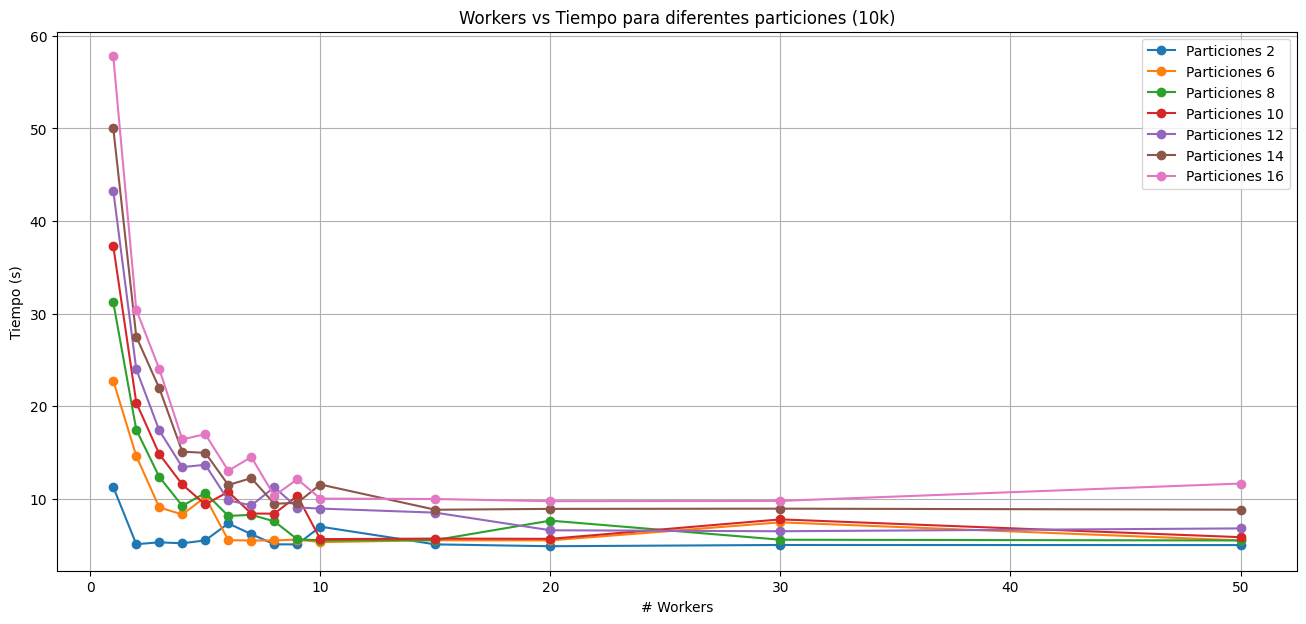

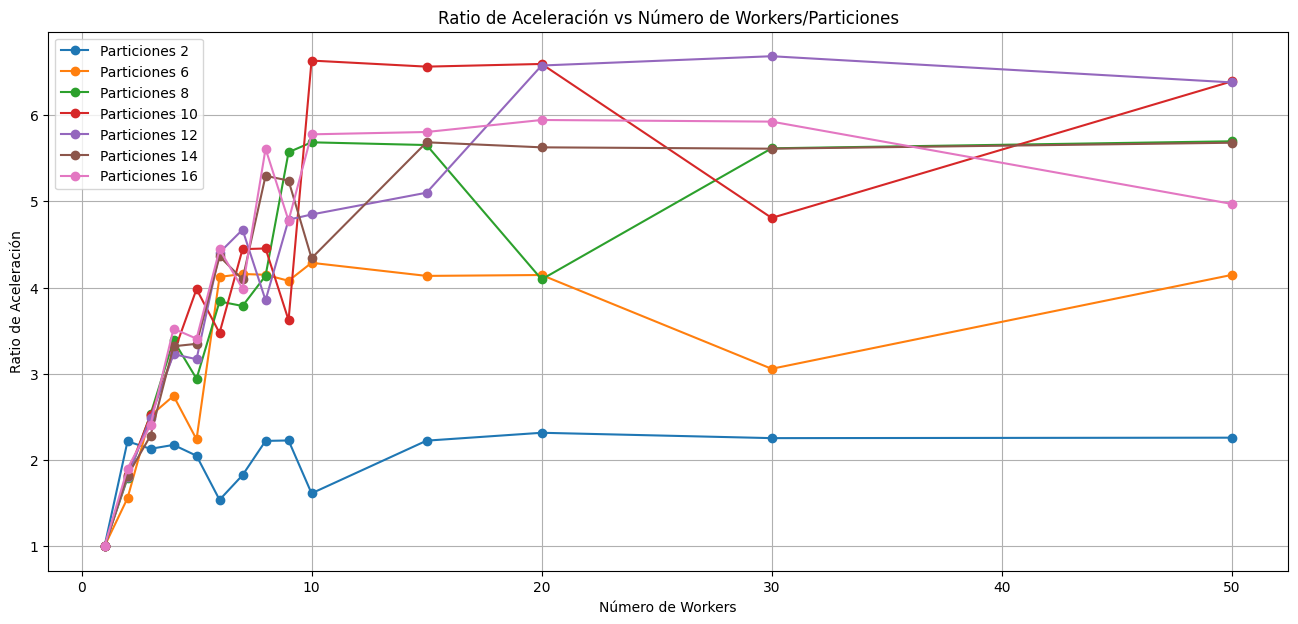

NameError: name 'inicial_incial' is not defined

In [30]:
inicial_inicial = time.time()
# Número de workers y particiones a probar
workers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50]
particiones = [2, 6, 8, 10, 12, 14, 16] 

try:
    sc.stop()
except:
    pass

plt.figure(figsize=(16, 7))
totals_por_particion = {}  # Almacenar tiempos por número de particiones

for p in particiones:
    totals = []  # Reiniciar la lista de tiempos para cada número de particiones
    
    for worker in tqdm(workers, desc=f"Workers (particiones={p})"):
        print(f"Workers: {worker}, Particiones: {p}")

        sc = SparkContext(f"local[{worker}]", "Name of the Program")
        n = readFile(file_path)   
        normalizado = normalize(n)
        normalizado=normalizado.repartition(p)

        inicio = time.time()
        w, b, costs = ej1_train(normalizado, 10, 1.5, p)  # Se cambia el número de particiones aquí
        fin = time.time()

        sc.stop()
        totals.append(fin - inicio)
    
    totals_por_particion[p] = totals  # Guardamos los tiempos de ejecución

    # Graficar en la misma figura
    plt.plot(workers, totals, marker='o', linestyle='-', label=f"Particiones {p}")

# Configurar la gráfica
plt.xlabel("# Workers")
plt.ylabel("Tiempo (s)")
plt.title("Workers vs Tiempo para diferentes particiones (million)")
plt.legend()
plt.grid()
plt.savefig("results/Ej_2_time_workers_million.png")
plt.show()

# ==========================
# Cálculo del Ratio de Aceleración
# ==========================

plt.figure(figsize=(16, 7))

for p in particiones:
    tiempos_workers_n = {w: totals_por_particion[p][i] for i, w in enumerate(workers)}
    tiempo_worker_1 = totals_por_particion[p][0]  # Tiempo con 1 worker
    ratios = {n: tiempo_worker_1 / t if t > 0 else None for n, t in tiempos_workers_n.items()}

    # Graficar el ratio de aceleración
    plt.plot(list(ratios.keys()), list(ratios.values()), marker='o', linestyle='-', label=f"Particiones {p}")

plt.xlabel("Número de Workers")
plt.ylabel("Ratio de Aceleración")
plt.title("Ratio de Aceleración vs Número de Workers/Particiones")
plt.legend()
plt.grid()
plt.savefig("results/Ej_X_speed_up_million.png")
plt.show()
final_final = time.time()
print(f"Tiempo de ejecución {(final_final - inicial_incial)/60} minutos")